## SWP-Group 1. Scripts – Walkthrough:

The goal is to use modified and unmodified graphs with some metadata as input to S<sup>2</sup>Match, after which we can evaluate our method. <br>

In order to do this you must already have an (STS|SICK)-dataset:

>1. which we then would convert to a tsv-file, that would contain sentences from all the categories and their scores <br>
>2. we can then use this tsv-file to create 2 files with AMRs in them (one file for sentences A and one file for sentences B) <br>
>3. for the AMR files we create AMR2Texts alignments <br>
>4. do some graph modification or extraction of metadata from these alignments (AMRAnalysis.py) <br>
>5. feed the results from 4) to S2Match <br>
>6. evaluate different approaches on original (STS|SICK)

### 1.0 Import and helper functions:

In [17]:
import argparse
import numpy as np
import pandas as pd
import subprocess, shlex
from pathlib import Path
from collections import defaultdict

def run_commands(commands, shell=False):
    """
    This function executes shell commands from a list of commands.
    The disadvantage of this function is that the output is only shown after execution.
   
   
    Args:
        commands (list): list of commands (str) to be executed
        shell (bool, optional): if "True" the process is executed through the shell
        
    """
    for command in commands:
        command = command.strip()
        print(f'"{command}"', '\nis being executed...','\n')
        res = subprocess.run(shlex.split(command), stdout=subprocess.PIPE, 
                             stderr=subprocess.STDOUT, text=True, shell=shell)
        for line in res.stdout.split('\n'):            
            if line:
                print(line)
        print()

# venvs on my PC, change according to your needs!
# win_env has the latest penman and amrlib
# linux_env has all dependencies for the AMR2Text-tool and penman==0.6.2
win_env   = 'conda activate dlp38 && python'
linux_env = 'wsl python3'

### 1.1 Running scripts to convert datasets to AMR and align them with text:

Commands to run in a shell:
```shell
{virtualenv} python3 sts2tsv.py -i datasets/sts/sts2016-english-with-gs-v1.0 -o data/STS2016_full.tsv 
{virtualenv with penman>=1.0} python3 to_amr.py -i data/STS2016_full.tsv -o data/amr/STS2016_corpus
{virtualenv with penman==0.6.2} python3 amr_pipeline.py -t AMR2Text -i data/STS2016_full.tsv -o data/amr/STS2016_corpus
```

### 1.1.1 Commands for STS-dataset:

In [1]:
commands_on_my_pc_sts = [
    f'{linux_env} sts2tsv.py -i datasets/sts/sts2016-english-with-gs-v1.0 -o data/STS2016_full.tsv',
    f'{win_env} tsv2amr.py -i data/STS2016_full_fix.tsv -o data/amr/STS2016_corpus',
    f'{linux_env} amr_pipeline.py -t AMR2Text -o data/amr/STS2016_corpus'
]

# Run here if necessary, but the output is not live (only after command is completed)!
#run_commands(commands_on_my_pc_sick, shell=True)

Loading model C:\ProgramData\Anaconda3\envs\dlp38\Lib\site-packages\amrlib\data\model_stog\model.pt
Stog model loaded sucessfully!


### 1.1.2 Commands for SICK-dataset + subsetting for neutral and positive entailment:

In [16]:
commands_on_my_pc_sick = [
    f'{win_env} sick2tsv.py -i datasets/sick/SICK2014_full.txt -o data/SICK2014.tsv --entailment_exclude contradiction',
    f'{win_env} tsv2amr.py -i data/SICK2014.tsv -o data/amr/SICK2014_corpus',
    f'{linux_env} amr_pipeline.py -t AMR2Text -o data/amr/SICK2014_corpus'
]

# Run here if necessary, but the output is not live (only after command is completed)!
run_commands(commands_on_my_pc_sick, shell=True)

"conda activate dlp38 && python sick2tsv.py -i datasets/sick/SICK2014_full.txt -o data/SICK2014.tsv --entailment_exclude contradiction" 
is being executed... 

File "datasets/sick/SICK2014_full.txt" successfully converted to "data/SICK2014.tsv"!



### 1.2 Resetting index in alignments files:

>The alignment tool is not perfect and sometimes it can't align certain sentences (in STS, in SICK we didn't have any errors). <br>
We could try to rewrite the code, so that these sentences are aligned, but it is pretty unfeasible, so we just throw all "bad" sentences out! <br> <br>
After we have discarded "bad" sentences from the alignments file, we, nonetheless, still want to maintain correct indices of the AMRs, so we have to reset the indexing. 

In [41]:
# 496 in b, others in a
sentences_with_errors_sts = [98, 119, 289, 296, 392, 496, 630, 654, 660]

def reset_ids_in_aligned():
    p = Path('.')/'data'/'amr'
    paths = [p/'STS2016_corpus_a_aligned.mrp', p/'STS2016_corpus_b_aligned.mrp']
    paths_to_save = [p/'STS2016_corpus_a_aligned_e.mrp', p/'STS2016_corpus_b_aligned_e.mrp']
    edited = []

    for i, p in enumerate(paths):
        content = p.read_text().split('\n\n')
        with open(paths_to_save[i], 'a') as out:
            for a, c in enumerate(content):
                if c:
                    lines = c.split('\n')
                    id_line_spl = lines[0].split()
                    id_line_spl[-1] = str(a)
                    lines[0] = ' '.join(id_line_spl)
                    c = '\n'.join(lines) + '\n\n'
                    out.write(c)

## 2. AMRAnalysis (transforming graphs or just adding alignments metadata):

In [11]:
commands = [
    f"""{win_env} AMRAnalysis.py -i data/amr/SICK2014_corpus_a_aligned.mrp data/amr/SICK2014_corpus_b_aligned.mrp \
    --output_prefix analysis/sick/SICK2014
    """,
    f"""{win_env} AMRAnalysis.py -i data/amr/SICK2014_corpus_a_aligned.mrp data/amr/SICK2014_corpus_b_aligned.mrp \
    --output_prefix analysis/sick/SICK2014 --extended_meta
    """,
    f"""{win_env} AMRAnalysis.py -i data/amr/SICK2014_corpus_a_aligned.mrp data/amr/SICK2014_corpus_b_aligned.mrp \
    --output_prefix analysis/sick/SICK2014 --concat_rel
    """,
    f"""{win_env} AMRAnalysis.py -i data/amr/STS2016_corpus_a_aligned.mrp data/amr/STS2016_corpus_b_aligned.mrp \
    --output_prefix analysis/sts/STS2016
    """,
    f"""{win_env} AMRAnalysis.py -i data/amr/STS2016_corpus_a_aligned.mrp data/amr/STS2016_corpus_b_aligned.mrp \
    --output_prefix analysis/sts/STS2016 --extended_meta
    """,
    f"""{win_env} AMRAnalysis.py -i data/amr/STS2016_corpus_a_aligned.mrp data/amr/STS2016_corpus_b_aligned.mrp \
    --output_prefix analysis/sts/STS2016 --concat_rel
    """,
]

run_commands(commands, shell=True)

"conda activate dlp38 && python AMRAnalysis.py -i data/amr/SICK2014_corpus_a_aligned.mrp data/amr/SICK2014_corpus_b_aligned.mrp     --output_prefix analysis/sick/SICK2014" 
is being executed... 

Input parameters: concat_rel=False, extended_meta=False
File: "analysis\sick\SICK2014_corpus_a_reif.amr" was sucessfully saved!
File: "analysis\sick\SICK2014_corpus_b_reif.amr" was sucessfully saved!

"conda activate dlp38 && python AMRAnalysis.py -i data/amr/SICK2014_corpus_a_aligned.mrp data/amr/SICK2014_corpus_b_aligned.mrp     --output_prefix analysis/sick/SICK2014 --extended_meta" 
is being executed... 

Input parameters: concat_rel=False, extended_meta=True
File: "analysis\sick\SICK2014_corpus_a_reif_ext.amr" was sucessfully saved!
File: "analysis\sick\SICK2014_corpus_b_reif_ext.amr" was sucessfully saved!

"conda activate dlp38 && python AMRAnalysis.py -i data/amr/SICK2014_corpus_a_aligned.mrp data/amr/SICK2014_corpus_b_aligned.mrp     --output_prefix analysis/sick/SICK2014 --concat_rel

In [42]:
# vectors are in "amr_suite/vectors/glove.6B.100d.txt"
# Run s2match script on both of them:
commands_block1 = [
    f"""{win_env} amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_glove.py \
    -f analysis/sick/SICK2014_corpus_a_reif.amr analysis/sick/SICK2014_corpus_b_reif.amr \
    -vectors amr_suite/vectors/glove.6B.100d.txt \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sick/s2match_glove_results/SICK2014_orig_results_full.txt
    """,
    
    f"""{win_env} amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_glove.py \
    -f analysis/sick/SICK2014_corpus_a_reif_ext.amr analysis/sick/SICK2014_corpus_b_reif_ext.amr \
    -vectors amr_suite/vectors/glove.6B.100d.txt \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sick/s2match_glove_results/SICK2014_concat_ver2_results_full.txt
    """,
    
    f"""{win_env} amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_glove.py \
    -f analysis/sick/SICK2014_corpus_a_concat.amr analysis/sick/SICK2014_corpus_b_concat.amr \
    -vectors amr_suite/vectors/glove.6B.100d.txt \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sick/s2match_glove_results/SICK2014_concat_ver1_results_full.txt
    """
]

commands_block2 = [
    f"""{win_env} amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_sbert.py \
    -f analysis/sick/SICK2014_corpus_a_reif.amr analysis/sick/SICK2014_corpus_b_reif.amr \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sick/s2match_sbert_results/SICK2014_orig_results_full.txt
    """,
    
    f"""{win_env} amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_sbert.py \
    -f analysis/sick/SICK2014_corpus_a_reif_ext.amr analysis/sick/SICK2014_corpus_b_reif_ext.amr \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sick/s2match_sbert_results/SICK2014_concat_ver2_results_full.txt
    """,
    
    f"""{win_env} amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_sbert.py \
    -f analysis/sick/SICK2014_corpus_a_concat.amr analysis/sick/SICK2014_corpus_b_concat.amr \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sick/s2match_sbert_results/SICK2014_concat_ver1_results_full.txt
    """
]

run_commands(commands_block1, shell=True)
run_commands(commands_block2, shell=True)

conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_glove.py     -f analysis/sick/SICK2014_corpus_a_reif.amr analysis/sick/SICK2014_corpus_b_reif.amr     -vectors amr_suite/vectors/glove.6B.100d.txt     -diffsense 0.5 -cutoff 0.5 -v --ms     > analysis/sick/s2match_glove_results/SICK2014_orig_results_full.txt
     
is being executed... 


conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_glove.py     -f analysis/sick/SICK2014_corpus_a_reif_ext.amr analysis/sick/SICK2014_corpus_b_reif_ext.amr     -vectors amr_suite/vectors/glove.6B.100d.txt     -diffsense 0.5 -cutoff 0.5 -v --ms     > analysis/sick/s2match_glove_results/SICK2014_concat_ver2_results_full.txt
     
is being executed... 

C:\ProgramData\Anaconda3\envs\dlp38\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)

conda activate dlp38 && python amr_suite/py3-Smatch-and-S2mat

In [47]:
import torch
from IPython.display import display
from sentence_transformers import SentenceTransformer, util

results1 = [
    Path('.')/'analysis'/'sick'/'s2match_glove_results'/'SICK2014_orig_results_full.txt',
    Path('.')/'analysis'/'sick'/'s2match_glove_results'/'SICK2014_concat_ver2_results_full.txt',
    Path('.')/'analysis'/'sick'/'s2match_glove_results'/'SICK2014_concat_ver1_results_full.txt'
]

results2 = [
    Path('.')/'analysis'/'sick'/'s2match_sbert_results'/'SICK2014_orig_results_full.txt',
    Path('.')/'analysis'/'sick'/'s2match_sbert_results'/'SICK2014_concat_ver2_results_full.txt',
    Path('.')/'analysis'/'sick'/'s2match_sbert_results'/'SICK2014_concat_ver1_results_full.txt'
]

def get_smatch_scores(path, rounded=False):
    """
    Extract scores from lines which start with 'Smatch score F1' 
    """
    prefix = 'Smatch score F1 '
    scores = []
    with open(path) as f:
        for line in f:
            if line.startswith(prefix):
                if rounded:
                    score = float(round(float(line.split()[-1])))
                else:
                    score = float(line.split()[-1])
                scores.append(score)
    return scores
        
smatch_glove_concat_ver1 = get_smatch_scores(results1[-1])
smatch_glove_concat_ver2 = get_smatch_scores(results1[1])
smatch_glove_orig        = get_smatch_scores(results1[0])

smatch_sbert_concat_ver1 = get_smatch_scores(results2[-1])
smatch_sbert_concat_ver2 = get_smatch_scores(results2[1])
smatch_sbert_orig        = get_smatch_scores(results2[0])

tsv_df = pd.read_csv(Path('.')/'data'/'SICK2014.tsv', sep='\t', header=0, 
                     usecols=['sent1', 'sent2', 'sick'], 
                     names=['sent1', 'sent2', 'sick'])

tsv_df['glove_orig'] = smatch_glove_orig[1:]
tsv_df['glove_v1']   = smatch_glove_concat_ver1[1:]
tsv_df['glove_v2']   = smatch_glove_concat_ver2[1:]

tsv_df['sbert_orig'] = smatch_sbert_orig[1:]
tsv_df['sbert_v1']   = smatch_sbert_concat_ver1[1:]
tsv_df['sbert_v2']   = smatch_sbert_concat_ver2[1:]

#tsv_df['sick'] = tsv_df['sick']/5

sbert = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
embeddings1 = sbert.encode(tsv_df['sent1'], convert_to_tensor=True)
embeddings2 = sbert.encode(tsv_df['sent2'], convert_to_tensor=True)
    
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
cosine_scores = torch.diagonal(cosine_scores)

tsv_df['sbert'] = cosine_scores

display(tsv_df.head(4))
#tsv_df.info()

,sent1,sent2,sick,glove_orig,glove_v1,glove_v2,sbert_orig,sbert_v1,sbert_v2,sbert
0,A man is putting garlic on some slices of bread,A man is putting garlic on some bread slices,1.0,0.917,0.841,0.917,0.917,0.811,0.917,0.975013
1,A rainbow afghan is being held by a girl in go...,A girl in gold and purple is holding a rainbow...,1.0,0.972,0.972,0.972,0.972,0.972,0.972,0.934562
2,A woman is playing an electric guitar,A woman is playing a guitar which is electric,1.0,1.000,0.897,1.000,1.000,0.832,1.000,0.975395
3,"Two women with folded arms, who are young, are...",Two young women with folded arms are looking a...,1.0,0.875,0.875,0.875,0.875,0.875,0.875,0.955399


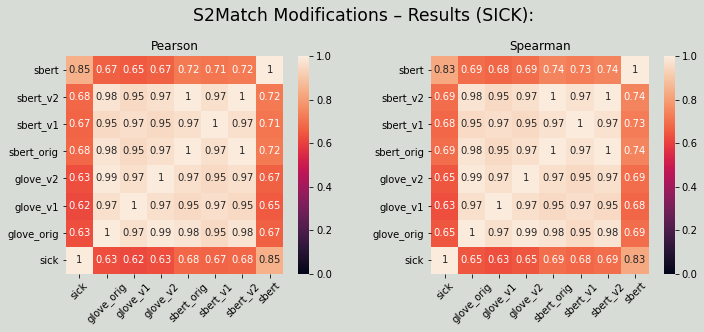

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_pearson  = tsv_df.corr(method='pearson')
corr_spearman = tsv_df.corr(method='spearman')
corrs = [corr_pearson, corr_spearman]

titles = ['Pearson', 'Spearman']
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.patch.set_facecolor('xkcd:light grey')
fig.suptitle('S2Match Modifications – Results (SICK):\n', fontsize='xx-large', y=1.05)

for corr_matrix, title, ax in zip(corrs, titles, axs.flat):
    #plt.figure(figsize=(5,5))
    ax = sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, vmin=0,
                     yticklabels=corr_matrix.columns, annot=True, square=True, 
                     ax=ax)
    ax.invert_yaxis()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)

fig.savefig(Path('.')/'analysis'/'sick'/'s2match_modification_results.png', 
            format='png', bbox_inches='tight')

## Other experiments (can be ignored):

#### Basic version of the concatenation function:

In [94]:
def concat_rel(g, rel=':mod'):  
    """Concatenates AMR triples of specified relation
    
    
    Args:
        g (penman.graph.Graph): graph with subgraphs to concatenate
        rel (str, optional): AMR graph relation to be concatenated
       
   """
    forbidden_nodes_with_instances = {}
    triples_filtered = []
    for triple in g.triples:
        if triple[1] == rel:
            invoked = triple[0]
            forbidden_node = triple[2]
            instance = [concept for node, _, concept in g.instances() if node == forbidden_node]
            if instance:
                forbidden_nodes_with_instances[forbidden_node] = (instance[0], invoked)
            else:
                forbidden_nodes_with_instances[forbidden_node] = ('', invoked)
        else:
            triples_filtered.append(triple)       
    for forbidden_node in forbidden_nodes_with_instances:
        instance, invoked = forbidden_nodes_with_instances[forbidden_node]
        for i in range(len(triples_filtered)):
            n, r, c = triples_filtered[i]
            if n == invoked and r == ':instance' and c != 'amr-unknown':
                triples_filtered[i] = (n, r, f'{instance}_{c}')
    triples_filtered = [t for t in triples_filtered if t[0] not in forbidden_nodes_with_instances]
    epidata = {(n, r, c):g.epidata[(n, r, c.split('_')[-1])] for n, r, c in triples_filtered}
    new_g = Graph(triples=triples_filtered, epidata=epidata)    
    return new_g

new_g = concat_rel(g, ':mod')
print(penman.encode(new_g), '\n')
print(penman.encode(g))

(MRPNode-0 / possible-01
           :ARG1 (MRPNode-1 / wrong-02
                            :ARG1 (MRPNode-2 / amr-unknown)
                            :ARG2 (MRPNode-3 / air_i_conditioner))) 

(MRPNode-0 / possible-01
           :ARG1 (MRPNode-1 / wrong-02
                            :ARG1 (MRPNode-2 / amr-unknown)
                            :ARG2 (MRPNode-3 / conditioner
                                             :mod (MRPNode-4 / i)
                                             :mod (MRPNode-5 / air))))


#### Similarity Measures: SBert models vs GloVe 6B.100d

In [1]:
import numpy as np
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer, util

In [2]:
def cos(a,b):
    """
    Calculates cosine similarity of two arrays.
    
    
    Args:
        a,b (array_like): arrays to calculate cosine similarity of
        
             
    
    Returns:
        sim (double): cosine similarity between a and b
        
    """
    dist = cosine(a,b)
    sim = 1 - min(1,dist)
    return sim

def load_glove(fp):
    """ 
    Loads GloVe vectors of file into a dictionary.
    
    
    Args:
        fp: path to file to get vectors from
        
    Returns:
        dic (dict): dictionary where keys are words and values are corresponding vectors
        
    """
    dic={}
    if not fp:
        return dic
    with open(fp,"r") as f:
        for line in f:
            ls = line.split()
            word = ls[0]
            vec = np.array([float(x) for x in ls[1:]])
            dic[word] = vec
    return dic

def vecs_of_sents(m, sents):
    """
    Averages vectors of words of sentences.
    
    
    Args:
        m: word embedding model
        sents (list): list of sentences to get vectors from
        
    Returns:
        s_vs (array): vector of sentences averaged over words
        
    """
    s_vs = np.asarray([np.sum([m[word] for word in sent.split()], axis=0)/len(sent.split()) for sent in sents])
    return s_vs

def print_scores(s1, s2, cosine_scores):
 
    max_s1 = max([len(s) for s in s1])
    max_s2 = max([len(s) for s in s2])
    
    for i in range(cosine_scores.shape[0]):
        for j in range(cosine_scores.shape[1]):
            print(f'{s1[i]:{max_s1}}\t{s2[j]:{max_s2}}\tScore: {cosine_scores[i, j]:.4f}')
            
def sbert_sim(model, s1, s2):
    embeddings1 = model.encode(s1, convert_to_tensor=True)
    embeddings2 = model.encode(s2, convert_to_tensor=True)
    
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    
    print_scores(s1, s2, cosine_scores)
            
def glove_sim(model, s1, s2):
    embeddings1 = vecs_of_sents(model, s1)
    embeddings2 = vecs_of_sents(model, s2)
    
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    
    print_scores(s1, s2, cosine_scores)


sbert1 = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
sbert2 = SentenceTransformer('paraphrase-distilroberta-base-v1')
glove  = load_glove('amr_suite/vectors/glove.6B.100d.txt')

In [3]:
#s1 = ['french fries']
#s2 = ['chip', 'chips']
s1 = ['We eat french fries.', 'We eat french fries .', 'We eat french fries']
s2 = ['We eat chips.', 'We eat chips .', 'We eat chips']

#s1_glove = ['how do i pump up water pressure in my shower ?']
#s2_glove = ['how can i boost the water pressure in my shower ?']

print('"paraphrase-distilroberta-base-v1":')
sbert_sim(sbert2, s1, s2)
print('\n')
print('"distilbert-base-nli-stsb-mean-tokens":')
sbert_sim(sbert1, s1, s2)

"""
print('\n')
print('"GloVe average":')
glove_sim(glove, s1, s2)
"""

"paraphrase-distilroberta-base-v1":
We eat french fries. 	We eat chips. 	Score: 0.5431
We eat french fries. 	We eat chips .	Score: 0.3898
We eat french fries. 	We eat chips  	Score: 0.5067
We eat french fries .	We eat chips. 	Score: 0.3834
We eat french fries .	We eat chips .	Score: 0.4945
We eat french fries .	We eat chips  	Score: 0.3968
We eat french fries  	We eat chips. 	Score: 0.5006
We eat french fries  	We eat chips .	Score: 0.3953
We eat french fries  	We eat chips  	Score: 0.5043


"distilbert-base-nli-stsb-mean-tokens":
We eat french fries. 	We eat chips. 	Score: 0.2958
We eat french fries. 	We eat chips .	Score: 0.2958
We eat french fries. 	We eat chips  	Score: 0.3143
We eat french fries .	We eat chips. 	Score: 0.2958
We eat french fries .	We eat chips .	Score: 0.2958
We eat french fries .	We eat chips  	Score: 0.3143
We eat french fries  	We eat chips. 	Score: 0.2940
We eat french fries  	We eat chips .	Score: 0.2940
We eat french fries  	We eat chips  	Score: 0.3407


'\nprint(\'\n\')\nprint(\'"GloVe average":\')\nglove_sim(glove, s1, s2)\n'